# Null-text inversion for stable preferences
The goal of this notebook is to be able to run the null-text inversion code and then experiment ways to use it for incorporating users' preferences in the generation process.

In [4]:
# pick a GPU
! export CUDA_VISIBLE_DEVICES=2

In [10]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import ptp_utils
import numpy as np
from PIL import Image
from typing import Optional, Union, List, Tuple
from tqdm import tqdm
from torch.optim.adam import Adam
import torch.nn.functional as nnf
from diffusers import UNet2DConditionModel
import seq_aligner


model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda:7"

In [11]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

In [12]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler = scheduler)
pipe = pipe.to(device)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 168615.24it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Run this cell only to check whether the stable diffusion pipeline is working

100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


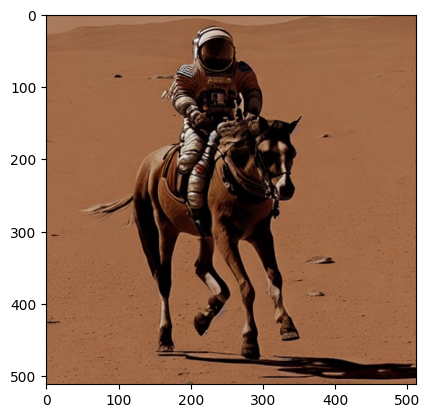

In [13]:
import matplotlib.pyplot as plt
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
plt.imshow(image)

Disable memory efficient attention

In [14]:
pipe.disable_xformers_memory_efficient_attention()

Some configurations

In [15]:
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77


In [16]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

In [17]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

In [18]:
class NullInversion:
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
        
    @property
    def scheduler(self):
        return self.model.scheduler
        
    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt
        
    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents
    
    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            #print(type(image))
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = unet(latents, t, encoder_hidden_states=context).sample
        return noise_pred
    
    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent
    
    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents
        
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
    

In [19]:
null_inversion = NullInversion(pipe)

In [20]:
image_path = "./example_images/gnochi_mirror.jpeg"
prompt = "a cat sitting next to a mirror"

In [21]:
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

DDIM inversion...
Null-text optimization...


100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


In [22]:
pipe.vae.to('cpu')#if gpu is full
decoded = pipe.vae.decode(x_t.to('cpu'))['sample']
piled = pipe.numpy_to_pil(decoded.detach().numpy()[0].T)
piled[0].save('test.png')

To reset GPU memory usage

In [15]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

# Run diffusion

In [24]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

In [25]:
import abc

        
class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn

class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):
    
    def step_callback(self, x_t):
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand(b, *x_t.shape[1:])
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)
        

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


In [26]:
def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = unet(latents, t, encoder_hidden_states=context[0]).sample
        noise_prediction_text = unet(latents, t, encoder_hidden_states=context[1]).sample
    else:
        latents_input = torch.cat([latents] * 2)
        noise_pred = unet(latents_input, t, encoder_hidden_states=context).sample
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    latents = controller.step_callback(latents)
    return latents

In [27]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent


In [29]:
prompts = [prompt]
controller = AttentionStore()
pipe.to(device)
images, x_t = text2image_ldm_stable(pipe, prompts, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None, uncond_embeddings=uncond_embeddings)


100%|██████████| 50/50 [00:08<00:00,  6.19it/s]


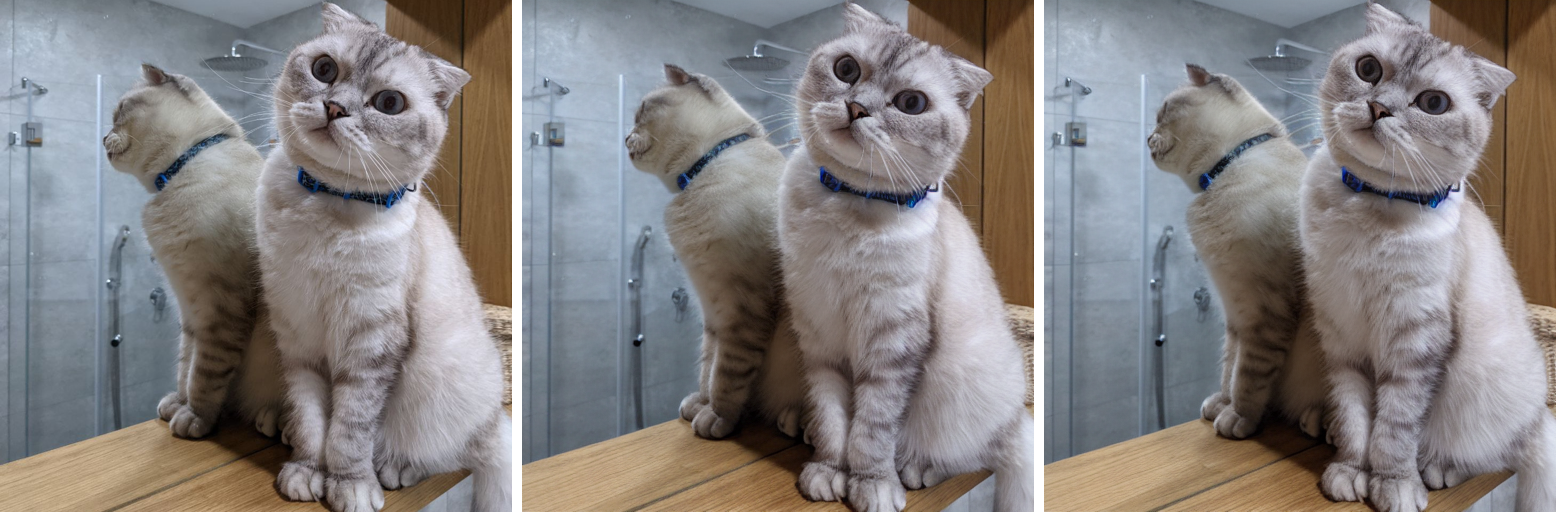

In [30]:
ptp_utils.view_images([image_gt, image_enc, images[0]])

In [31]:
controller = AttentionStore()
pipe.to(device)

images_no_unc, x_t_no_unc = text2image_ldm_stable(pipe, [prompt], controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None)

100%|██████████| 50/50 [00:08<00:00,  6.17it/s]


If we do not use unconditional embeddings and we start from the same x_t using the same positive prompt we obtain this image

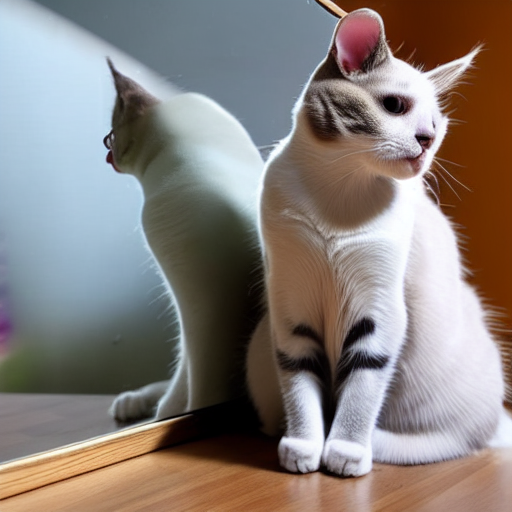

In [156]:
ptp_utils.view_images([images_no_unc[0]])

Here I experiment what happens if I slightly change the capture but I keep x_t and the unconditional embeddings as before

In [161]:
prompts_modified = ["a dog sitting next to a mirror"]
controller = AttentionStore()
pipe.to('cuda:2')

images_modified, x_t_modified = text2image_ldm_stable(pipe, prompts_modified, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None, uncond_embeddings=uncond_embeddings)


100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


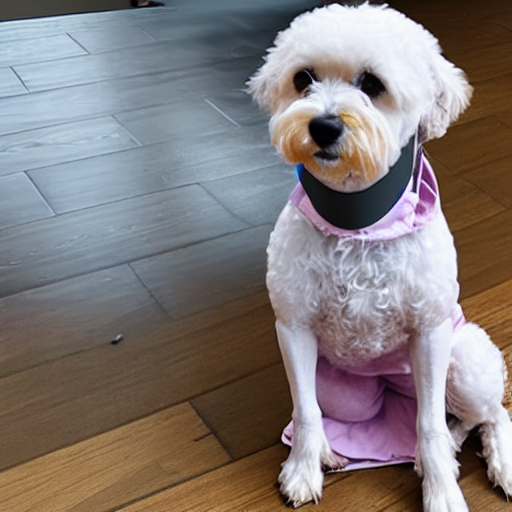

In [162]:
ptp_utils.view_images([images_modified[0]])

The following should be the code of the part which uses attention masks to modify the image. However, it is still not working so I commented it out

In [86]:
# def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
#                   Tuple[float, ...]]):
#     if type(word_select) is int or type(word_select) is str:
#         word_select = (word_select,)
#     equalizer = torch.ones(1, 77)
    
#     for word, val in zip(word_select, values):
#         inds = ptp_utils.get_word_inds(text, word, tokenizer)
#         equalizer[:, inds] = val
#     return equalizer
# class LocalBlend:
    
#     def get_mask(self, maps, alpha, use_pool):
#         k = 1
#         maps = (maps * alpha).sum(-1).mean(1)
#         if use_pool:
#             maps = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
#         mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
#         mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
#         mask = mask.gt(self.th[1-int(use_pool)])
#         mask = mask[:1] + mask
#         return mask
    
#     def __call__(self, x_t, attention_store):
#         self.counter += 1
#         if self.counter > self.start_blend:
#             print(attention_store)
#             maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
#             maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
#             maps = torch.cat(maps, dim=1)
#             mask = self.get_mask(maps, self.alpha_layers, True)
#             if self.substruct_layers is not None:
#                 maps_sub = ~self.get_mask(maps, self.substruct_layers, False)
#                 mask = mask * maps_sub
#             mask = mask.float()
#             x_t = x_t[:1] + mask * (x_t - x_t[:1])
#         return x_t
       
#     def __init__(self, prompts: List[str], words: [List[List[str]]], substruct_words=None, start_blend=0.2, th=(.3, .3)):
#         alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
#         for i, (prompt, words_) in enumerate(zip(prompts, words)):
#             if type(words_) is str:
#                 words_ = [words_]
#             for word in words_:
#                 ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
#                 alpha_layers[i, :, :, :, :, ind] = 1
        
#         if substruct_words is not None:
#             substruct_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
#             for i, (prompt, words_) in enumerate(zip(prompts, substruct_words)):
#                 if type(words_) is str:
#                     words_ = [words_]
#                 for word in words_:
#                     ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
#                     substruct_layers[i, :, :, :, :, ind] = 1
#             self.substruct_layers = substruct_layers.to(device)
#         else:
#             self.substruct_layers = None
#         self.alpha_layers = alpha_layers.to(device)
#         self.start_blend = int(start_blend * NUM_DDIM_STEPS)
#         self.counter = 0 
#         self.th=th

# class AttentionControlEdit(AttentionStore, abc.ABC):
    
#     def step_callback(self, x_t):
#         if self.local_blend is not None:
#             x_t = self.local_blend(x_t, self.attention_store)
#         return x_t
        
#     def replace_self_attention(self, attn_base, att_replace, place_in_unet):
#         if att_replace.shape[2] <= 32 ** 2:
#             attn_base = attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
#             return attn_base
#         else:
#             return att_replace
    
#     @abc.abstractmethod
#     def replace_cross_attention(self, attn_base, att_replace):
#         raise NotImplementedError
    
#     def forward(self, attn, is_cross: bool, place_in_unet: str):
#         super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
#         if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
#             h = attn.shape[0] // (self.batch_size)
#             attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
#             attn_base, attn_repalce = attn[0], attn[1:]
#             if is_cross:
#                 alpha_words = self.cross_replace_alpha[self.cur_step]
#                 attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
#                 attn[1:] = attn_repalce_new
#             else:
#                 attn[1:] = self.replace_self_attention(attn_base, attn_repalce, place_in_unet)
#             attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
#         return attn
    
#     def __init__(self, prompts, num_steps: int,
#                  cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
#                  self_replace_steps: Union[float, Tuple[float, float]],
#                  local_blend: Optional[LocalBlend]):
#         super(AttentionControlEdit, self).__init__()
#         self.batch_size = len(prompts)
#         self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
#         if type(self_replace_steps) is float:
#             self_replace_steps = 0, self_replace_steps
#         self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
#         self.local_blend = local_blend
        
# def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
#     if blend_words is None:
#         lb = None
#     else:
#         lb = LocalBlend(prompts, blend_word)
#     if is_replace_controller:
#         controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
#     else:
#         controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
#     if equilizer_params is not None:
#         eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
#         controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
#                                        self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
#     return controller

# class AttentionReweight(AttentionControlEdit):

#     def replace_cross_attention(self, attn_base, att_replace):
#         if self.prev_controller is not None:
#             attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
#         attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
#         # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
#         return attn_replace

#     def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
#                 local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
#         super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
#         self.equalizer = equalizer.to(device)
#         self.prev_controller = controller


# class AttentionReplace(AttentionControlEdit):

#     def replace_cross_attention(self, attn_base, att_replace):
#         return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
#     def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
#                  local_blend: Optional[LocalBlend] = None):
#         super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
#         self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

In [76]:
# tokenizer = pipe.tokenizer

In [87]:
# prompts = ["a cat sitting next to a mirror",
#            "a tiger sitting next to a mirror"
#         ]

# cross_replace_steps = {'default_': .8,}
# self_replace_steps = .5
# blend_word = ((('cat',), ("tiger",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
# eq_params = {"words": ("tiger",), "values": (2,)} # amplify attention to the word "tiger" by *2 

# controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
